In [1]:
import pandas as pd
import os
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import requests

# When the data analysis should stop
LAST_DAY = pd.Timestamp("2024-04-10")

# Adjust this based on data availibility
FIRST_DAY = pd.Timestamp("2018-01-01")

In [2]:
def get_csv(url, local_filename):
    if not os.path.exists(local_filename):
        print(f"{local_filename} not found locally. Downloading and reading from URL...")
        df = pd.read_csv(url)
        df.to_csv(local_filename, index=False)  # Save the downloaded file locally
    else:
        print(f"Reading {local_filename} from local storage...")
        df = pd.read_csv(local_filename)
    return df

In [3]:
# MONTREAL/PIERRE ELLIOTT TRUDEAU INTL QUEBEC
# This station has precipitation but doesn't have a categorical value of weather (e.g cloudy, rain, etc)
station_id = "30165"

def get_weather_csvs(y_start, y_end):
  # Range does not include the end
  for year in range(y_start, y_end):
    for month in range(1, 13):
      filename = f"weather_{year}_{month}.csv"
      if not os.path.exists(filename):
        response = requests.get(f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station_id}&Year={year}&Month={month}&Day=1&timeframe=1&submit=Download+Data")
        if response.status_code == 200:
          with open(filename, 'wb') as file:
              file.write(response.content)
          print(f"Downloaded {filename}")
        else:
          print(f"Failed downloading {filename}")
      else:
        print(f"Reading {filename} from local storage...")


In [4]:
def plot_preds(df):
  # Plot on a smaller dataset
  df = df.set_index('datetime')
  # Plotting
  plt.figure(figsize=(10, 5))  # Set the figure size for better readability
  plt.plot(df['Actual'], label='Actual AQI', color='blue')  # Plot the actual AQI values
  plt.plot(df['Predicted'], label='Predicted AQI', color='red')  # Plot the predicted AQI values with a dashed line
  plt.title('Comparison of Actual and Predicted AQI')  # Title of the plot
  plt.xlabel('Date')  # Label for the x-axis
  plt.ylabel('AQI Value')  # Label for the y-axis
  plt.legend()  # Add a legend to distinguish the lines
  plt.grid(True)  # Add grid for better readability of the plot
  plt.show()  # Display the plot

In [5]:
def mk_analysis_df(df, preds):
  _df = pd.DataFrame({'datetime': df['datetime'],
              'Actual': df['valeur'],
              'Predicted': preds })
  _df['Percentage Error'] = np.abs(_df['Actual'] - _df['Predicted']) / _df['Actual'] * 100

  return _df

# Temp data exploration

- [Glossary](https://climate.weather.gc.ca/glossary_e.html)

In [6]:
y_start, y_end = (FIRST_DAY.year, LAST_DAY.year)

#hide
get_weather_csvs(y_start, y_end + 1)

Downloaded weather_2018_1.csv
Downloaded weather_2018_2.csv
Downloaded weather_2018_3.csv
Downloaded weather_2018_4.csv
Downloaded weather_2018_5.csv
Downloaded weather_2018_6.csv
Downloaded weather_2018_7.csv
Downloaded weather_2018_8.csv
Downloaded weather_2018_9.csv
Downloaded weather_2018_10.csv
Downloaded weather_2018_11.csv
Downloaded weather_2018_12.csv
Downloaded weather_2019_1.csv
Downloaded weather_2019_2.csv
Downloaded weather_2019_3.csv
Downloaded weather_2019_4.csv
Downloaded weather_2019_5.csv
Downloaded weather_2019_6.csv
Downloaded weather_2019_7.csv
Downloaded weather_2019_8.csv
Downloaded weather_2019_9.csv
Downloaded weather_2019_10.csv
Downloaded weather_2019_11.csv
Downloaded weather_2019_12.csv
Downloaded weather_2020_1.csv
Downloaded weather_2020_2.csv
Downloaded weather_2020_3.csv
Downloaded weather_2020_4.csv
Downloaded weather_2020_5.csv
Downloaded weather_2020_6.csv
Downloaded weather_2020_7.csv
Downloaded weather_2020_8.csv
Downloaded weather_2020_9.csv
Down

In [8]:
all_files = []
for filename in os.listdir("."):
  if filename.startswith("weather_"):
    all_files.append(pd.read_csv(filename))

weather_df = pd.concat(all_files)
weather_df.rename(columns={'Date/Time (LST)': 'datetime', "Temp (°C)": "temp", "Precip. Amount (mm)": "precip"}, inplace=True)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])



# TODO: for the temp we should look at the day before or after instead of using 0
weather_df.fillna({"precip": 0, "temp": 0}, inplace=True)
weather_df = weather_df[['datetime', "precip", "temp"]]


# Only take data from the first known and last known day
weather_df = weather_df[(weather_df['datetime'] <= LAST_DAY) & (weather_df['datetime'] < LAST_DAY)]

weather_df.sort_values("datetime", inplace=True)

assert weather_df[weather_df.isna().any(axis=1)].empty == True

weather_df

,datetime,precip,temp
0,2018-01-01 00:00:00,0.0,-24.3
1,2018-01-01 01:00:00,0.0,-22.4
2,2018-01-01 02:00:00,0.0,-22.6
3,2018-01-01 03:00:00,0.0,-22.8
4,2018-01-01 04:00:00,0.0,-23.7
...,...,...,...
211,2024-04-09 19:00:00,0.0,15.0
212,2024-04-09 20:00:00,0.0,13.4
213,2024-04-09 21:00:00,0.0,12.6
214,2024-04-09 22:00:00,0.0,11.7


# AQI data exploration

### The accuracy is shit so here some things to try:
- [ ] External data
- [ ] Different date feature engineering approach
- [ ] Remove/leave pollutant
- [ ] Model ensembling
- [x] Use random forests


Compare results with https://aqicn.org/city/montreal/

In [9]:
df1 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv', '2022-2024.csv')
df2 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/e43dc1d6-fbdd-49c3-a79f-83f63404c281/download/rsqa-indice-qualite-air-2019-2021.csv', '2019-2021.csv')
df3 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/93a3a88e-97ab-4ab1-813f-5419a1dd330d/download/rsqa-indice-qualite-air-2016-2018.csv", "2016-2018.csv")
# df4 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/02cfaf0c-3b46-4dac-bf66-acd2ff47361a/download/rsqa-indice-qualite-air-2013-2015.csv", "2013-2015.csv")
# df5 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/6e59c6e9-749b-4237-9c45-5c627be2b7ad/download/rsqa-indice-qualite-air-2010-2012.csv", "2010-2012.csv")

2022-2024.csv not found locally. Downloading and reading from URL...
2019-2021.csv not found locally. Downloading and reading from URL...
2016-2018.csv not found locally. Downloading and reading from URL...


In [10]:
df = pd.concat([df1, df2, df3])
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',

                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
df.drop(["heure", "polluant", "date"], axis=1, inplace=True)
df.sort_values("datetime", inplace=True)

df['year'] = df['datetime'].dt.year

# Year has a bigger number range than the rest so we divide it up by its maximum
df['year'] = df['year'] / df['year'].max()
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour

# Taking a sample of data for a given datetime and station id
# df[(df["stationId"] == 103) & (df["datetime"] == "2024-04-15 19:00:00")]

df = df[(df['datetime'] >= FIRST_DAY) & (df['datetime'] < LAST_DAY)]
df

,stationId,valeur,datetime,year,month,day,weekday,hour
667149,7,2,2018-01-01 00:00:00,0.997036,1,1,0,0
550004,17,2,2018-01-01 00:00:00,0.997036,1,1,0,0
550003,17,17,2018-01-01 00:00:00,0.997036,1,1,0,0
717710,28,15,2018-01-01 00:00:00,0.997036,1,1,0,0
717711,28,3,2018-01-01 00:00:00,0.997036,1,1,0,0
...,...,...,...,...,...,...,...,...
764425,3,7,2024-04-09 23:00:00,1.000000,4,9,1,23
764424,3,1,2024-04-09 23:00:00,1.000000,4,9,1,23
739046,17,20,2024-04-09 23:00:00,1.000000,4,9,1,23
764423,3,20,2024-04-09 23:00:00,1.000000,4,9,1,23


In [11]:
# the data contains measurements across various stations (spread over the MTL territory).
# We can take the maximum measurement for a given station for a given datetime (regardless of the pollutant).
# Note: we are assuming each pollutant contributes equally to the AQI level
# (Using the maximum pollutant value as a representative AQI is simplistic. Real AQI calculation may involve more complex computations where different pollutants have different weights or scale adjustments based on their health impact.)
group1_df = df.groupby(['stationId', 'datetime']).max("valeur")

# Manually verifying the maximum has been taken for a given station id on a given datetime
group1_df

valeur      year  month  day  weekday  hour
stationId datetime                                                        
3         2018-01-01 00:00:00      13  0.997036      1    1        0     0
          2018-01-01 01:00:00      15  0.997036      1    1        0     1
          2018-01-01 02:00:00      14  0.997036      1    1        0     2
          2018-01-01 03:00:00      16  0.997036      1    1        0     3
          2018-01-01 04:00:00      17  0.997036      1    1        0     4
...                               ...       ...    ...  ...      ...   ...
103       2024-04-09 19:00:00      25  1.000000      4    9        1    19
          2024-04-09 20:00:00      20  1.000000      4    9        1    20
          2024-04-09 21:00:00      22  1.000000      4    9        1    21
          2024-04-09 22:00:00      22  1.000000      4    9        1    22
          2024-04-09 23:00:00      21  1.000000      4    9        1    23

[593874 rows x 6 columns]

In [15]:
# Get the mean across all station maximums for each datetime
group2_df = group1_df.groupby("datetime").mean("valeur")
group2_df['date'] = group2_df.index.date
group2_df.reset_index(inplace=True)

merged = pd.merge(group2_df, weather_df, on="datetime", how="left")

# merged[merged['datetime'] >= pd.Timestamp("2023-10-01")]
merged

,datetime,valeur,year,month,day,weekday,hour,date,precip,temp
0,2018-01-01 00:00:00,15.000000,0.997036,1.0,1.0,0.0,0.0,2018-01-01,0.0,-24.3
1,2018-01-01 01:00:00,15.454545,0.997036,1.0,1.0,0.0,1.0,2018-01-01,0.0,-22.4
2,2018-01-01 02:00:00,14.363636,0.997036,1.0,1.0,0.0,2.0,2018-01-01,0.0,-22.6
3,2018-01-01 03:00:00,13.636364,0.997036,1.0,1.0,0.0,3.0,2018-01-01,0.0,-22.8
4,2018-01-01 04:00:00,14.454545,0.997036,1.0,1.0,0.0,4.0,2018-01-01,0.0,-23.7
...,...,...,...,...,...,...,...,...,...,...
54979,2024-04-09 19:00:00,22.818182,1.000000,4.0,9.0,1.0,19.0,2024-04-09,0.0,15.0
54980,2024-04-09 20:00:00,21.272727,1.000000,4.0,9.0,1.0,20.0,2024-04-09,0.0,13.4
54981,2024-04-09 21:00:00,20.727273,1.000000,4.0,9.0,1.0,21.0,2024-04-09,0.0,12.6
54982,2024-04-09 22:00:00,19.727273,1.000000,4.0,9.0,1.0,22.0,2024-04-09,0.0,11.7


In [16]:
split_date_valid = pd.Timestamp('2022-01-01')
split_date_test = pd.Timestamp('2023-06-01')

train_idx = merged['datetime'] < split_date_valid
valid_idx = (merged['datetime'] >= split_date_valid) & (merged['datetime'] < split_date_test)
test_idx = merged['datetime'] >= split_date_test

train_idxs = np.where(train_idx)[0].tolist()
valid_idxs = np.where(valid_idx)[0].tolist()
test_idxs = np.where(test_idx)[0].tolist()

len(merged.loc[train_idxs]), len(valid_idxs)

(35064, 12384)

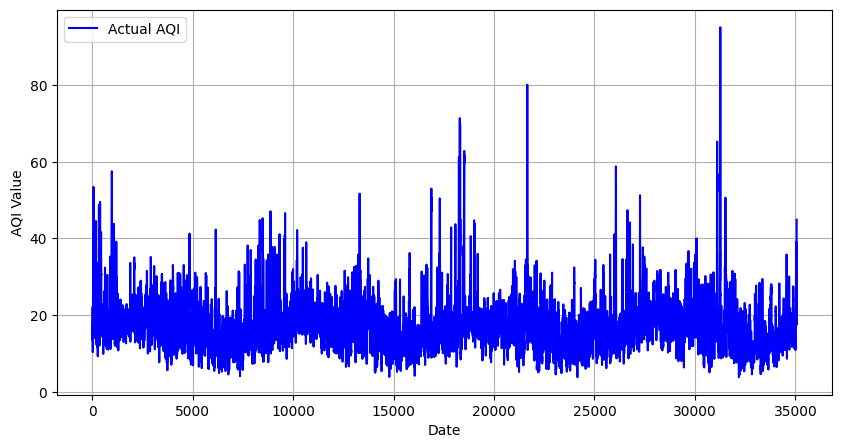

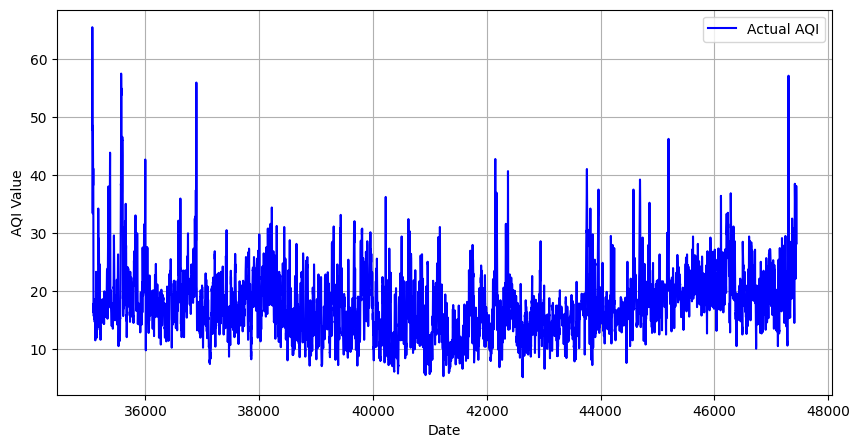

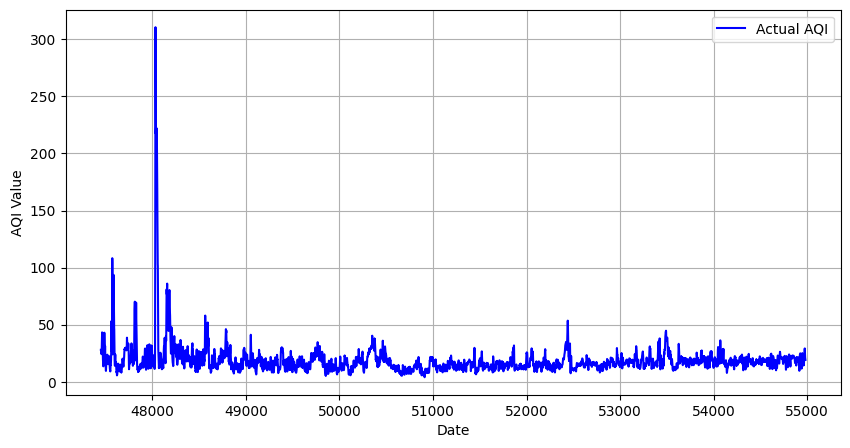

In [ ]:
def plot_aqi(xs):
  plt.figure(figsize=(10, 5))  # Set the figure size for better readability
  plt.plot(xs, label='Actual AQI', color='blue')  # Plot the actual AQI values
  plt.xlabel('Date')  # Label for the x-axis
  plt.ylabel('AQI Value')  # Label for the y-axis
  plt.legend()  # Add a legend to distinguish the lines
  plt.grid(True)  # Add grid for better readability of the plot
  plt.show()  # Display the plot


plot_aqi(merged.iloc[train_idxs]['valeur'])
plot_aqi(merged.iloc[valid_idxs]['valeur'])
plot_aqi(merged.iloc[test_idxs]['valeur'])


In [17]:
dls = TabularPandas(
  merged,
  procs=[Normalize],
  cat_names=[],
  cont_names=['year', 'month', 'day', 'weekday', 'hour', "precip", "temp"],
  y_names=['valeur'],
  splits=(train_idxs, valid_idxs),
  y_block=RegressionBlock()
).dataloaders(500)

dls.show_batch()

,year,month,day,weekday,hour,precip,temp,valeur
0,0.998024,7.0,29.0,2.0,4.0,0.0,20.000000,15.090909
1,0.998024,8.0,1.0,5.0,8.0,0.0,22.799999,9.727273
2,0.998518,7.0,5.0,0.0,7.0,0.0,18.799999,8.818182
3,0.998518,9.0,18.0,5.0,9.0,0.0,19.100000,14.818182
4,0.997036,12.0,3.0,0.0,9.0,0.5,2.100000,12.400000
5,0.998518,9.0,21.0,1.0,18.0,0.0,21.100000,15.636364
6,0.997530,9.0,15.0,6.0,5.0,0.0,13.600000,15.800000
7,0.998518,5.0,30.0,6.0,4.0,0.0,8.100000,13.363636
8,0.997036,5.0,20.0,6.0,15.0,0.0,20.200001,21.272728
9,0.997036,1.0,16.0,1.0,15.0,0.0,-10.200000,16.363636


# Neural net impl

In [18]:
learn = tabular_learner(dls, metrics=mae, layers=[10, 10])

SuggestedLRs(valley=0.033113110810518265, slide=6.309573450380412e-07)

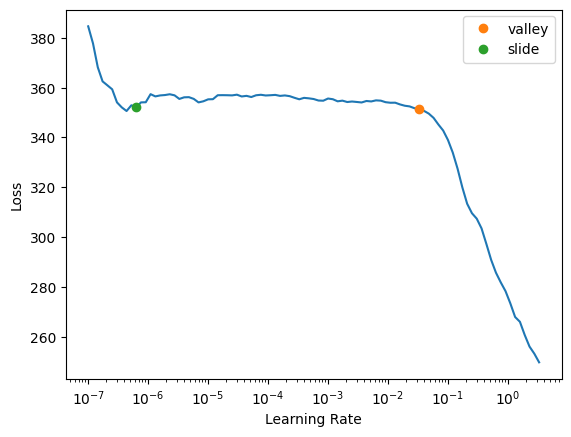

In [57]:
learn.lr_find(suggest_funcs=[valley, slide])

In [19]:
learn.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,mae,time
0,342.999268,336.953278,17.530287,00:01
1,254.321457,125.963287,10.004785,00:01
2,89.649223,24.237188,3.516533,00:01
3,42.919636,22.707680,3.379031,00:00
4,31.141802,23.432049,3.413244,00:00
5,28.179123,23.460859,3.413621,00:00
6,27.548096,23.422649,3.393137,00:01
7,27.096405,23.113764,3.344930,00:01
8,27.063021,23.365913,3.368113,00:01
9,26.950077,23.279928,3.366025,00:00


In [ ]:
# learn.recorder.plot_loss()
learn.show_results(max_n=10)

,year,month,day,weekday,hour,total_precip,mean_temp,valeur,valeur_pred
0,3.130295,-0.731559,-0.082912,1.002141,-1.372399,-0.444298,0.668750,20.090910,16.987185
1,2.235817,-0.151631,1.394345,-0.998718,0.939010,-0.444298,1.066418,21.090910,22.222103
2,2.235817,1.588153,0.371628,-1.498932,-0.216695,-0.444298,-0.828849,17.727272,15.649229
3,2.235817,-0.441595,-0.196548,1.002141,0.505621,-0.444298,1.362553,25.000000,30.514603
4,2.235817,-1.021523,1.167075,1.002141,-1.227936,-0.444298,-0.278883,13.636364,17.807108
5,2.235817,-0.151631,-0.196548,-0.998718,-0.072232,-0.444298,1.083340,18.000000,21.675869
6,2.235817,0.428297,0.144358,-0.498503,1.661325,-0.444298,1.235638,12.545455,15.816430
7,2.235817,1.588153,0.257993,1.502356,-1.227936,-0.444298,-0.837310,19.000000,18.104996
8,2.235817,-0.441595,1.621615,-1.498932,-0.505621,-0.444298,1.176411,15.000000,21.577770
9,2.235817,1.298190,-0.878359,-0.998718,-0.650084,-0.444298,-0.371955,13.909091,13.665561


In [20]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [21]:
preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

TensorBase(4.8959)

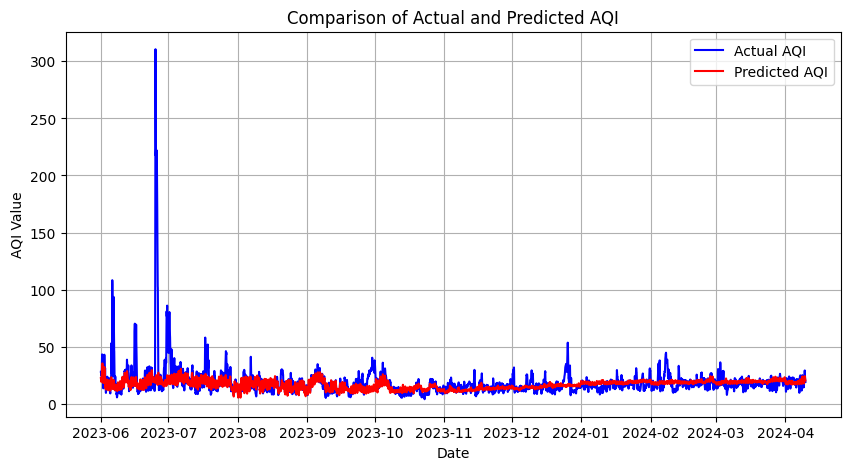

In [23]:
analysis_df = mk_analysis_df(df_test, preds.flatten())

plot_preds(analysis_df)

# Random forest impl

_RandomForest doesn't seem to offer much better results than using deep learning for this dataset._

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import torch

m = RandomForestRegressor(n_jobs=-1, n_estimators=100,
        max_samples=10_000, max_features=0.5,
        min_samples_leaf=5, oob_score=True).fit(dls.train.xs, dls.train.y)
preds = m.predict(dls.valid.xs)
preds_tensor = torch.tensor(preds)

mae(preds_tensor, torch.tensor(dls.valid.y.values))

TensorBase(3.5762)

In [ ]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [ ]:
preds = torch.tensor(m.predict(test_dl.xs))
mae(preds, torch.tensor(test_dl.y.values))

TensorBase(5.1510)

In [ ]:
analysis_df = mk_analysis_df(df_test, preds)
analysis_df

,datetime,Actual,Predicted,Percentage Error
47448,2023-06-01 00:00:00,28.000000,21.656352,22.655886
47449,2023-06-01 01:00:00,28.000000,21.617084,22.796128
47450,2023-06-01 02:00:00,26.636364,21.800669,18.154485
47451,2023-06-01 03:00:00,26.545455,21.725506,18.157342
47452,2023-06-01 04:00:00,25.545455,21.745445,14.875482
...,...,...,...,...
54979,2024-04-09 19:00:00,22.818182,20.305180,11.013153
54980,2024-04-09 20:00:00,21.272727,18.967463,10.836714
54981,2024-04-09 21:00:00,20.727273,17.878750,13.742875
54982,2024-04-09 22:00:00,19.727273,17.744184,10.052523


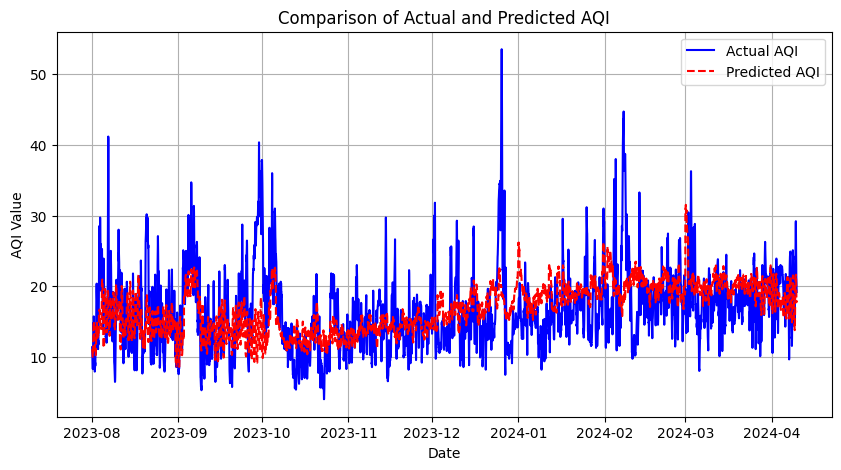

In [ ]:
plot_preds(analysis_df)